In [ ]:
from jaxl.constants import *
from jaxl.datasets import get_dataset
from jaxl.learning_utils import get_learner
from jaxl.plot_utils import set_size
from jaxl.utils import parse_dict

import jax
import jax.numpy as jnp
import jax.random as jrandom
import json
import math
import numpy as np
import optax
import os

from orbax.checkpoint import PyTreeCheckpointer, CheckpointManager

In [ ]:
base_dir = "/Users/chanb/research/personal/jaxl/jaxl"
# learner_path = "/Users/chanb/research/personal/jaxl/jaxl/logs/icl-noiseless-no_bias-2d_linear-active_dim_2-context_len_20-hinge/gpt-pos_enc-09-13-23_18_05_50-a5570248-2817-445b-aba0-0881b85184fd/"
# learner_path = "/Users/chanb/research/personal/jaxl/jaxl/logs/icl-noiseless-no_bias-2d_linear-active_dim_2-context_len_8/gpt-pos_enc-09-13-23_18_06_16-4c30c90d-5f51-4ca8-970b-3b39d2582f90"
learner_path = "/Users/chanb/research/personal/jaxl/jaxl/logs/icl-noiseless-no_bias-2d_linear-active_dim_2-context_len_8/default-09-15-23_10_06_09-d24e0ff2-341c-4899-b5ae-4f9406de2e45"
# learner_path = "/Users/chanb/research/personal/jaxl/jaxl/logs/icl-noiseless-no_bias-2d_linear-active_dim_2-context_len_8/hinge-09-15-23_10_06_20-cc99805e-ba12-41b3-9ee8-faf49561f1e2"
test_dataset_seed = 999
sequence_len = 80
num_tasks = 30
# num_tasks = 5

# For plotting
doc_width_pt = 1000.0

In [ ]:
config_path = os.path.join(learner_path, "config.json")
with open(config_path, "r") as f:
    config_dict = json.load(f)
    config = parse_dict(config_dict)

learner = get_learner(
    config.learner_config, config.model_config, config.optimizer_config
)

checkpoint_manager = CheckpointManager(
    os.path.join(learner_path, "models"),
    PyTreeCheckpointer(),
)

params = checkpoint_manager.restore(checkpoint_manager.latest_step())
params[CONST_MODEL_DICT][CONST_MODEL][CONST_POSITIONAL_ENCODING] = dict()
llm_model = learner._model

In [ ]:
config.learner_config.dataset_config

In [ ]:
input_range = [-1.0, 1.0]
test_config = vars(config.learner_config.dataset_config)
test_config["dataset_kwargs"] = vars(test_config["dataset_kwargs"])
test_config["dataset_kwargs"]["num_sequences"] = num_tasks
test_config["dataset_kwargs"]["sequence_length"] = sequence_len + 1
test_config["dataset_kwargs"]["params_bound"] = [-0.5, 0.5]
test_config["dataset_kwargs"]["inputs_range"] = input_range
ns_test_config = parse_dict(test_config)

In [ ]:
test_dataset = get_dataset(ns_test_config, seed=test_dataset_seed)
unwrapped_dataset = test_dataset._dataset

In [ ]:
test_dataset[0][3].shape

In [ ]:
print(unwrapped_dataset._inputs.shape, unwrapped_dataset._targets.shape)

In [ ]:
context_len = config.learner_config.dataset_config.dataset_wrapper.kwargs.context_len


def get_result(dataset, task_i, context_len):
    context_inputs, context_outputs = [], []
    for context_i in range(context_len):
        context_inputs.append(dataset._inputs[task_i, context_i])
        context_outputs.append(dataset._targets[task_i, context_i])
    context_inputs = np.stack(context_inputs)
    context_outputs = np.stack(context_outputs)

    queries = dataset._inputs[task_i, context_len:]
    outputs = dataset._targets[task_i, context_len:]

    preds, _ = jax.vmap(llm_model.forward, in_axes=[None, 0, None])(
        params[CONST_MODEL_DICT][CONST_MODEL],
        queries[:, None, None],
        {
            CONST_CONTEXT_INPUT: context_inputs[None, :],
            CONST_CONTEXT_OUTPUT: context_outputs[None, :],
        },
    )
    return queries, preds, outputs, context_inputs, context_outputs

In [ ]:
def ce_loss(logits, y_one_hot):
    return np.mean(optax.softmax_cross_entropy(logits, y_one_hot))

# Analysis

In [ ]:
import matplotlib.pyplot as plt

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
res = {}

for task_i in range(num_tasks):
    queries, preds, outputs, context_inputs, context_outputs = get_result(
        unwrapped_dataset, task_i, context_len
    )
    preds = preds[:, 0, -1]
    loss = ce_loss(preds, outputs)
    res.setdefault(task_i, {})
    res[task_i]["data"] = {
        "context_inputs": context_inputs,
        "context_outputs": context_outputs,
        "queries": queries,
        "outputs": outputs,
    }
    res[task_i]["llm"] = preds

    gt = test_dataset.params[task_i]
    res[task_i]["gt"] = -np.array(input_range) * gt[1] / gt[2]


In [ ]:
svm_regs = [1e-2, 1e-1, 5e-1, 1.0, 2.0, 10.0, 100.0, 1000.0]
lr_regs = [1e-2, 1e-1, 5e-1, 1.0, 2.0, 10.0, 100.0, 1000.0]
knn_ks = [1, 3]

### K-NN

In [ ]:
def make_knn(inputs, outputs, num_neighbours):
    knn = make_pipeline(
        KNeighborsClassifier(
            n_neighbors=num_neighbours,
        )
    )
    knn.fit(inputs, np.argmax(outputs, axis=1))
    return knn

In [ ]:
for task_i in range(num_tasks):
    knns = {}
    context_inputs = res[task_i]["data"]["context_inputs"]
    context_outputs = res[task_i]["data"]["context_outputs"]

    for idx, k in enumerate(knn_ks):

        knns[k] = make_knn(context_inputs, context_outputs, k)

    res[task_i]["knn"] = knns

### SVM

In [ ]:
def make_svm(inputs, outputs, reg_coef):
    svm = make_pipeline(
        LinearSVC(
            C=reg_coef,
            max_iter=2000,
        ),
    )
    svm.fit(inputs, np.argmax(outputs, axis=1))
    return svm

In [ ]:
svm_info = {}

for task_i in range(num_tasks):
    svms = {}
    svm_info.setdefault(task_i, {})

    # ncols = 4
    # nrows = math.ceil(len(svm_regs) / ncols)
    # fig, axes = plt.subplots(
    #     nrows,
    #     ncols,
    #     figsize=set_size(doc_width_pt, 0.95, (nrows, ncols), False),
    #     layout="constrained",
    # )

    context_inputs = res[task_i]["data"]["context_inputs"]
    context_outputs = res[task_i]["data"]["context_outputs"]

    for idx, svm_reg in enumerate(svm_regs):
        # if nrows == 1:
        #     ax = axes[idx]
        # else:
        #     ax = axes[idx // ncols, idx % ncols]

        svms[svm_reg] = make_svm(context_inputs, context_outputs, svm_reg)

        decision_function = svms[svm_reg].decision_function(context_inputs)
        support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
        support_vectors = context_inputs[support_vector_indices]

        svm_info[task_i][svm_reg] = {
            "support_vectors": support_vectors,
            "support_labels": context_outputs[support_vector_indices]
        }

    #     ax.plot(
    #         np.array(input_range),
    #         res[task_i]["gt"],
    #         label="Ground truth" if idx == 0 else "",
    #         color="red",
    #         alpha=0.3,
    #     )

    #     ax.scatter(
    #         context_inputs[:, 0],
    #         context_inputs[:, 1],
    #         c=context_outputs[:, -1],
    #         s=30,
    #         cmap=plt.cm.Paired,
    #     )
    #     DecisionBoundaryDisplay.from_estimator(
    #         svms[svm_reg],
    #         context_inputs,
    #         ax=ax,
    #         grid_resolution=50,
    #         plot_method="contour",
    #         colors="k",
    #         levels=[-1, 0, 1],
    #         alpha=0.5,
    #         linestyles=["--", "-", "--"],
    #     )
    #     ax.scatter(
    #         support_vectors[:, 0],
    #         support_vectors[:, 1],
    #         s=100,
    #         linewidth=1,
    #         facecolors="none",
    #         edgecolors="k",
    #     )
    #     ax.set_xlim(input_range[0], input_range[1])
    #     ax.set_ylim(input_range[0], input_range[1])
    #     ax.set_title(f"Reg. Coef.: {svm_reg}")

    # fig.legend(
    #     bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    #     loc="lower center",
    #     ncols=3,
    #     borderaxespad=0.0,
    #     frameon=True,
    #     fontsize="8",
    # )
    # fig.supxlabel("$x_1$")
    # fig.supylabel("$x_2$")
    # plt.tight_layout()
    # plt.show()

    res[task_i]["svm"] = svms

### Logistic Regression

In [ ]:
def make_lr(inputs, outputs, penalty, reg_coef):
    logistic_regression = make_pipeline(LogisticRegression(
        penalty=penalty,
        C=reg_coef,
        max_iter=2000,
    ))
    logistic_regression.fit(inputs, np.argmax(outputs, axis=1))
    return logistic_regression

In [ ]:
for task_i in range(num_tasks):
    lrs = {}

    # ncols = 4
    # nrows = math.ceil(len(lr_regs) / ncols)
    # fig, axes = plt.subplots(
    #     nrows,
    #     ncols,
    #     figsize=set_size(doc_width_pt, 0.95, (nrows, ncols), False),
    #     layout="constrained",
    # )

    context_inputs = res[task_i]["data"]["context_inputs"]
    context_outputs = res[task_i]["data"]["context_outputs"]

    for idx, lr_reg in enumerate(lr_regs):
        # if nrows == 1:
        #     ax = axes[idx]
        # else:
        #     ax = axes[idx // ncols, idx % ncols]

        # ax.plot(
        #     np.array(input_range),
        #     res[task_i]["gt"],
        #     label="Ground truth" if idx == 0 else "",
        #     color="red",
        #     alpha=0.3,
        # )

        lrs[lr_reg] = make_lr(context_inputs, context_outputs, "l2", lr_reg)
    #     ax.scatter(
    #         context_inputs[:, 0],
    #         context_inputs[:, 1],
    #         c=context_outputs[:, -1],
    #         s=30,
    #         cmap=plt.cm.Paired,
    #     )
    #     DecisionBoundaryDisplay.from_estimator(
    #         lrs[lr_reg],
    #         context_inputs,
    #         ax=ax,
    #         grid_resolution=50,
    #         plot_method="contour",
    #         colors="k",
    #         levels=[0],
    #         alpha=0.5,
    #         linestyles=["-"],
    #     )
    #     ax.set_xlim(input_range[0], input_range[1])
    #     ax.set_ylim(input_range[0], input_range[1])
    #     ax.set_title(f"Reg. Coef.: {lr_reg}")

    # fig.legend(
    #     bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    #     loc="lower center",
    #     ncols=3,
    #     borderaxespad=0.0,
    #     frameon=True,
    #     fontsize="8",
    # )
    # fig.supxlabel("$x_1$")
    # fig.supylabel("$x_2$")
    # plt.tight_layout()
    # plt.show()
    res[task_i]["lr"] = lrs

### ICL Analysis

In [ ]:
model_preds = {}
num_models = len(lr_regs) + len(svm_regs)

delta = 0.01
xs_grid = np.arange(-1.0, 1.0 + delta, delta)
test_queries = np.stack(np.meshgrid(xs_grid, xs_grid)).reshape((2, -1)).T

In [ ]:
for task_i in range(num_tasks):
    context_inputs = res[task_i]["data"]["context_inputs"]
    context_outputs = res[task_i]["data"]["context_outputs"]

    model_preds.setdefault(task_i, {})
    llm_preds, _ = jax.vmap(llm_model.forward, in_axes=[None, 0, None])(
        params[CONST_MODEL_DICT][CONST_MODEL],
        test_queries[:, None, None],
        {
            CONST_CONTEXT_INPUT: context_inputs[None, :],
            CONST_CONTEXT_OUTPUT: context_outputs[None, :],
        },
    )
    llm_preds = llm_preds[:, 0, -1]
    model_preds[task_i]["llm"] = llm_preds

In [ ]:
for task_i in range(num_tasks):
    ncols = 4
    nrows = math.ceil(num_models / ncols)
    fig, axes = plt.subplots(
        nrows,
        ncols,
        figsize=set_size(doc_width_pt, 0.95, (nrows, ncols), False),
        layout="constrained",
    )

    model_classes = {
        "SVM": res[task_i]["svm"],
        "LR": res[task_i]["lr"],
    }

    llm_preds = model_preds[task_i]["llm"]
    llm_pred_labels = np.argmax(llm_preds, axis=-1)

    model_i = 0
    for model_class, models in model_classes.items():
        for reg_coef, model in models.items():
            model_out = (
                -(np.array(input_range) * model[0].coef_[0, 0] + model[0].intercept_[0])
                / model[0].coef_[0, 1]
            )

            if nrows == 1:
                ax = axes[model_i]
            else:
                ax = axes[model_i // ncols, model_i % ncols]

            for possible_label in [0, 1]:
                idxes = np.where(llm_pred_labels == possible_label)
                ax.scatter(
                    test_queries[idxes][:, 0],
                    test_queries[idxes][:, 1],
                    label=f"{possible_label}" if model_i == 0 else "",
                    s=5,
                )

            if model_class == "SVM":
                ax.scatter(
                    svm_info[task_i][reg_coef]["support_vectors"][:, 0],
                    svm_info[task_i][reg_coef]["support_vectors"][:, 1],
                    label="support vector" if model_i == 0 else "",
                    color="black"
                )

            ax.plot(
                np.array(input_range),
                res[task_i]["gt"],
                label="Ground truth" if model_i == 0 else "",
                color="black",
                linewidth=1,
            )

            ax.plot(np.array(input_range), model_out, color="blue", linewidth=1, label="Comparator" if model_i == 0 else "")

            ax.set_xlim(input_range[0], input_range[1])
            ax.set_ylim(input_range[0], input_range[1])
            ax.set_title(f"{model_class} {reg_coef}")
            model_i += 1


    fig.legend(
        bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
        loc="lower center",
        ncols=4,
        borderaxespad=0.0,
        frameon=True,
        fontsize="8",
    )
    fig.supxlabel("$x_1$")
    fig.supylabel("$x_2$")
    plt.tight_layout()
    plt.show()

### Mean 0-1 Prediction Difference

In [ ]:
losses = {}

for task_i in range(num_tasks):
    model_classes = {
        "SVM": res[task_i]["svm"],
        "LR": res[task_i]["lr"],
        "KNN": res[task_i]["knn"],
    }

    llm_preds = np.argmax(model_preds[task_i]["llm"], axis=1)
    for model_class, models in model_classes.items():
        for reg_coef, model in models.items():
            losses.setdefault((model_class, reg_coef), [])
            losses[(model_class, reg_coef)].append(np.mean(model.predict(test_queries) == llm_preds))

for model_info, curr_loss in losses.items():
    print("{}: {:.2f}% +/- {:.2f}".format(model_info, np.mean(curr_loss) * 100, np.std(curr_loss * 100)))

### Context Using Support Vector

In [ ]:
def get_new_pairs(support_vectors, support_labels, query, context_len):
    support_vectors = jnp.concatenate((
        support_vectors,
        query,
        jnp.zeros((context_len - len(support_vectors), *support_vectors.shape[1:])),
    ))
    support_labels = jnp.concatenate((
        support_labels,
        jnp.zeros((context_len - len(support_labels), *support_labels.shape[1:])),
    ))
    return support_vectors, support_labels


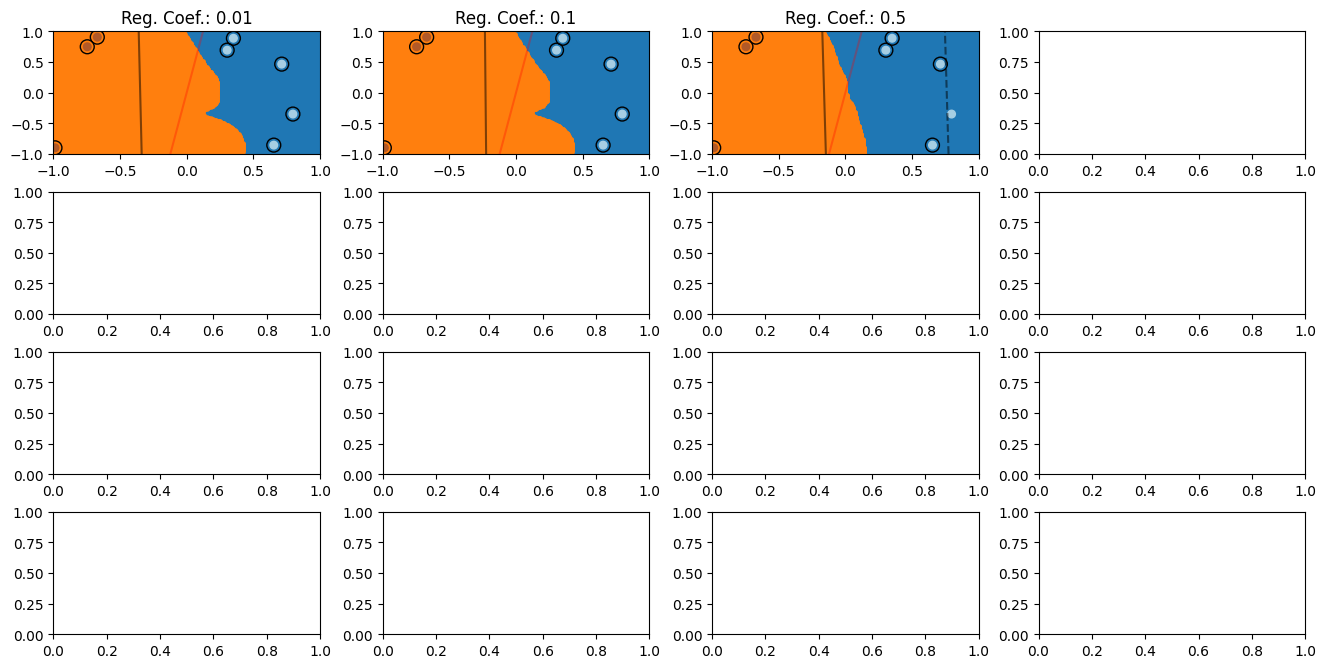

In [30]:
context_res = {}

for task_i in range(num_tasks):
    context_res.setdefault(task_i, {})

    ncols = 4
    nrows = math.ceil(len(svm_regs) / ncols)
    fig, axes = plt.subplots(
        nrows + 2,
        ncols,
        figsize=set_size(doc_width_pt, 0.95, (nrows, ncols), False),
        layout="constrained",
    )

    context_inputs = res[task_i]["data"]["context_inputs"]
    context_outputs = res[task_i]["data"]["context_outputs"]

    for idx, svm_reg in enumerate(svm_regs):
        if nrows == 1:
            ax = axes[idx]
        else:
            ax = axes[idx // ncols, idx % ncols]
        support_vectors = svm_info[task_i][svm_reg]["support_vectors"]
        support_labels = svm_info[task_i][svm_reg]["support_labels"]
        
        num_support_vectors = len(support_vectors)
        inputs, outputs = jax.vmap(get_new_pairs, in_axes=[None, None, 0, None])(
            support_vectors,
            support_labels,
            test_queries[:, None],
            context_len
        )

        # Use support vectors as context
        llm_preds, _ = llm_model.forward(
            params[CONST_MODEL_DICT][CONST_MODEL],
            inputs[:, [-1]],
            {
                CONST_CONTEXT_INPUT: inputs[:, :-1],
                CONST_CONTEXT_OUTPUT: outputs,
            },
        )
        llm_preds = llm_preds[:, num_support_vectors]
        context_res[task_i]["llm"] = llm_preds
        context_res[task_i]["support_vectors"] = support_vectors
        context_res[task_i]["support_labels"] = support_labels

        llm_pred_labels = np.argmax(llm_preds, axis=-1)

        for possible_label in [0, 1]:
            idxes = np.where(llm_pred_labels == possible_label)
            if len(idxes[0]) == 0:
                continue
            ax.scatter(
                test_queries[idxes][:, 0],
                test_queries[idxes][:, 1],
                label=f"{possible_label}" if model_i == 0 else "",
                s=5,
            )

        ax.plot(
            np.array(input_range),
            res[task_i]["gt"],
            label="Ground truth" if idx == 0 else "",
            color="red",
            alpha=0.3,
        )

        ax.scatter(
            context_inputs[:, 0],
            context_inputs[:, 1],
            c=context_outputs[:, -1],
            s=30,
            cmap=plt.cm.Paired,
        )
        DecisionBoundaryDisplay.from_estimator(
            res[task_i]["svm"][svm_reg],
            context_inputs,
            ax=ax,
            grid_resolution=50,
            plot_method="contour",
            colors="k",
            levels=[-1, 0, 1],
            alpha=0.5,
            linestyles=["--", "-", "--"],
        )
        ax.scatter(
            svm_info[task_i][svm_reg]["support_vectors"][:, 0],
            svm_info[task_i][svm_reg]["support_vectors"][:, 1],
            s=100,
            linewidth=1,
            facecolors="none",
            edgecolors="k",
        )
        ax.set_xlim(input_range[0], input_range[1])
        ax.set_ylim(input_range[0], input_range[1])
        ax.set_title(f"Reg. Coef.: {svm_reg}")

    for idx, k in enumerate([1, 3, 5, 7]):
        if nrows == 1:
            ax = axes[idx]
        else:
            ax = axes[nrows, idx % ncols]

        knn = make_knn(context_inputs, context_outputs, k)
        knn_preds = knn.predict(test_queries)
        
        for possible_label in [0, 1]:
            idxes = np.where(knn_preds == possible_label)
            if len(idxes[0]) == 0:
                continue
            ax.scatter(
                test_queries[idxes][:, 0],
                test_queries[idxes][:, 1],
                label=f"{possible_label}" if model_i == 0 else "",
                s=5,
            )
        ax.set_xlim(input_range[0], input_range[1])
        ax.set_ylim(input_range[0], input_range[1])
        ax.set_title(f"K: {k}")

    for idx, k in enumerate([1, 3, 5, 7]):
        if nrows == 1:
            ax = axes[idx]
        else:
            ax = axes[nrows + 1, idx % ncols]
        
        ax.set_title(f"K: {k}")
        ax.set_xlim(input_range[0], input_range[1])
        ax.set_ylim(input_range[0], input_range[1])
        if len(support_vectors) < k:
            continue

        knn = make_knn(support_vectors, support_labels, k)
        knn_preds = knn.predict(test_queries)
        for possible_label in [0, 1]:
            idxes = np.where(knn_preds == possible_label)
            if len(idxes[0]) == 0:
                continue
            ax.scatter(
                test_queries[idxes][:, 0],
                test_queries[idxes][:, 1],
                label=f"{possible_label}" if model_i == 0 else "",
                s=5,
            )

    fig.legend(
        bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
        loc="lower center",
        ncols=3,
        borderaxespad=0.0,
        frameon=True,
        fontsize="8",
    )
    fig.supxlabel("$x_1$")
    fig.supylabel("$x_2$")
    plt.tight_layout()
    plt.show()

### Permute Support Vectors

In [ ]:
permute_res = {}

num_permutations = 4
perm_seed = 9999

permutation_keys = jrandom.split(jrandom.PRNGKey(perm_seed), 4)

for task_i in range(num_tasks):
    permute_res.setdefault(task_i, {})

    ncols = 4
    nrows = math.ceil((len(svm_regs) * num_permutations) / ncols)
    fig, axes = plt.subplots(
        nrows,
        ncols,
        figsize=set_size(doc_width_pt, 0.95, (nrows, ncols), False),
        layout="constrained",
    )

    context_inputs = res[task_i]["data"]["context_inputs"]
    context_outputs = res[task_i]["data"]["context_outputs"]

    ax_idx = 0
    for idx, svm_reg in enumerate(svm_regs):
        for permutation_key in permutation_keys:
            if nrows == 1:
                ax = axes[ax_idx]
            else:
                ax = axes[ax_idx // ncols, ax_idx % ncols]
            support_vectors = svm_info[task_i][svm_reg]["support_vectors"]
            support_labels = svm_info[task_i][svm_reg]["support_labels"]

            perm_idxes = jrandom.permutation(permutation_key, x=np.arange(len(support_vectors)))
            support_vectors = support_vectors[perm_idxes]
            support_labels = support_labels[perm_idxes]

            num_support_vectors = len(support_vectors)
            inputs, outputs = jax.vmap(get_new_pairs, in_axes=[None, None, 0, None])(
                support_vectors,
                support_labels,
                test_queries[:, None],
                context_len
            )

            # Use support vectors as context
            llm_preds, _ = llm_model.forward(
                params[CONST_MODEL_DICT][CONST_MODEL],
                inputs[:, [-1]],
                {
                    CONST_CONTEXT_INPUT: inputs[:, :-1],
                    CONST_CONTEXT_OUTPUT: outputs,
                },
            )
            llm_preds = llm_preds[:, num_support_vectors]
            permute_res[task_i]["llm"] = llm_preds
            permute_res[task_i]["support_vectors"] = support_vectors
            permute_res[task_i]["support_labels"] = support_labels

            llm_pred_labels = np.argmax(llm_preds, axis=-1)

            for possible_label in [0, 1]:
                idxes = np.where(llm_pred_labels == possible_label)
                if len(idxes[0]) == 0:
                    continue
                ax.scatter(
                    test_queries[idxes][:, 0],
                    test_queries[idxes][:, 1],
                    label=f"{possible_label}" if ax_idx == 0 else "",
                    s=5,
                )

            ax.plot(
                np.array(input_range),
                res[task_i]["gt"],
                label="Ground truth" if ax_idx == 0 else "",
                color="red",
                alpha=0.3,
            )

            ax.scatter(
                context_inputs[:, 0],
                context_inputs[:, 1],
                c=context_outputs[:, -1],
                s=30,
                cmap=plt.cm.Paired,
            )
            DecisionBoundaryDisplay.from_estimator(
                res[task_i]["svm"][svm_reg],
                context_inputs,
                ax=ax,
                grid_resolution=50,
                plot_method="contour",
                colors="k",
                levels=[-1, 0, 1],
                alpha=0.5,
                linestyles=["--", "-", "--"],
            )
            ax.scatter(
                svm_info[task_i][svm_reg]["support_vectors"][:, 0],
                svm_info[task_i][svm_reg]["support_vectors"][:, 1],
                s=100,
                linewidth=1,
                facecolors="none",
                edgecolors="k",
            )
            ax.set_xlim(input_range[0], input_range[1])
            ax.set_ylim(input_range[0], input_range[1])
            ax.set_title(f"Reg. Coef.: {svm_reg}")
            ax_idx += 1

    fig.legend(
        bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
        loc="lower center",
        ncols=3,
        borderaxespad=0.0,
        frameon=True,
        fontsize="8",
    )
    fig.supxlabel("$x_1$")
    fig.supylabel("$x_2$")
    plt.tight_layout()
    plt.show()